In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import glob, os
import pylab
%matplotlib inline



In [2]:
store = pd.HDFStore(r'H:\fast trip\Muni\apc_1203.h5')
data1 = store['APCdata']

In [3]:
data1.columns

Index([u'stop_sequence', u'block', u'route', u'unique_stop_no', u'stop_name', u'arr_hour', u'arr_min', u'arr_sec', u'dep_hr', u'dep_min', u'dep_sec', u'on', u'off', u'load', u'loadcode', u'mo', u'day', u'yr', u'sched_pattern', u'latitude', u'longitude', u'distance', u'door_cycles', u'delta', u'trip', u'dow', u'direction', u'delta_miles', u'delta_minutes', u'delta_pass_miles', u'delta_pass_hours', u'vehno', u'line_apc', u'data_batch', u'sched_time', u'sched_run_time', u'distance_gps', u'sched_dev', u'actual_time', u'dwell_time_interval', u'sign_up_date', u'gps_qc', u'count_qc', u'assignment_qc', u'rec_type', u'wheelchair', u'bikerack', u'import_vers', u'unadj_on', u'unadj_off', u'capacity', u'over_cap', u'north_south', u'east_west'], dtype='object')

In [4]:
#bus info
vehicles = pd.read_csv(r'H:\fast trip\SF\Vehicles.csv')
fleet = pd.read_csv(r'H:\fast trip\SF\Copy of Fleet.csv')
vehicles.Artic = vehicles.Length.map({60 : 1, 40 : 0, 30 : 0})
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']


In [5]:
#prepare variables
def get_x_y(data):
    #Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['on', 'off', 'vehno'])
    #input bus type info into raw data
    #COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['EOL']= data.apply(lambda x: '- EOL' in x['stop_name'], axis=1).map({False: 1, True: 0})
    #remove the last stop
    data = data.loc[data['EOL'] == 1]
    #remove the first stop
    data = data.loc[data['stop_sequence'] != 1]
    #COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    data['COMPUTE_TIMESTOP'] = data.apply(lambda row: (row['arr_hour']*3600 + row['arr_min']*60 + row['arr_sec']), axis=1)
    #COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data.apply(lambda row: (row['dep_hr']*3600 + row['dep_min']*60 + row['dep_sec']), axis=1)
    #COMPUTE DOORDWELL=DOORCLOSE-TIMESTOP
    data['COMPUTE_DOORDWELL'] = data.apply(lambda row: (row['COMPUTE_DOORCOLSE'] - row['COMPUTE_TIMESTOP']), axis=1)
    #appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    
    #Keep rows that satisfy a query:
    data['Doors'] = data['vehno'].map(df_vehnum_doors) 
    data['Artic'] = data['vehno'].map(df_vehnum_artic)
    data['Floor'] = data['vehno'].map(df_vehnum_floor)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    #interaction variables
    data['on_threedoors'] = data.apply(lambda row: (row['on']*row['three_doors']), axis=1)
    data['off_threedoors'] = data.apply(lambda row: (row['off']*row['three_doors']), axis=1)
    data['on_floor'] = data.apply(lambda row: (row['on']*row['Floor']), axis=1)
    data['off_floor'] = data.apply(lambda row: (row['off']*row['Floor']), axis=1)

    return data

In [6]:
data = get_x_y(data1)

In [7]:
#build model
lm = smf.ols(formula = 'COMPUTE_DOORDWELL ~ on + off + Floor + three_doors + on_threedoors + off_threedoors + on_floor + off_floor', data = data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      COMPUTE_DOORDWELL   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                 6.804e+05
Date:                Mon, 11 Jan 2016   Prob (F-statistic):               0.00
Time:                        13:00:15   Log-Likelihood:            -3.5216e+07
No. Observations:             9038798   AIC:                         7.043e+07
Df Residuals:                 9038789   BIC:                         7.043e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.3618      0.006    773.711      0.000         4.351     4.373
on                 2.7365      0.002   1317.896      0.000         2.732     2.741
off                1.7074      0.002    825.612      0.000         1.703     1.711
Floor             -2.1576      0.013   -169.731      0.000        -2.182    -2.133
three_doors        2.0518      0.012    171.284      0.000         2.028     2.075
on_threedoors     -0.3622      0.003   -109.002      0.000        -0.369    -0.356
off_threedoors    -0.4292      0.003   -130.443      0.000        -0.436    -0.423
on_floor           0.5379      0.006     83.345      0.000         0.525     0.551
off_floor          0.5608      0.006     86.941      0.000         0.548     0.573
==============================================================================
Omnibus:                  5228141.309   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3499299761.620
Skew:                           1.412   Prob(JB):                         0.00
Kurtosis:                      99.351   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
results = data[['on', 'off', 'three_doors', 'Floor']]
results.corr()

,on,off,three_doors,Floor
on,1.000000,0.263881,0.134110,-0.083411
off,0.263881,1.000000,0.132714,-0.083198
three_doors,0.134110,0.132714,1.000000,-0.213478
Floor,-0.083411,-0.083198,-0.213478,1.000000


In [9]:
store = pd.HDFStore(r'H:\fast trip\Muni\apc_1206.h5')
data2 = store['APCdata']
store = pd.HDFStore(r'H:\fast trip\Muni\apc_1209.h5')
data3 = store['APCdata']
print 'finish reading'

finish reading


In [10]:
#plotting
#Appling 10% of data3 as test dataset
msk = np.random.rand(len(data3)) < 0.9
train = data3[msk]
test = data3[~msk]
df_test = get_x_y(test)
df_test['ON+OFF'] = df_test.apply(lambda row: (row['on']+row['off']), axis=1)
print 'end'

end


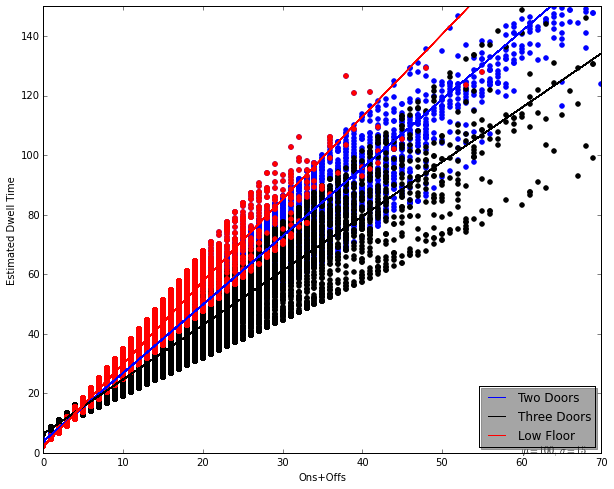

In [14]:
#prepare y-axis
#Estimate dwell time for the 'test' dataset
df_est = []
df_est = pd.DataFrame(lm.predict(df_test), index = df_test.index, columns = ['Dwell_Time_Esti'])
df_test = pd.concat([df_test, df_est], axis=1, join='inner')
df_test.head()

#prepare x-axis
df_test_TwoDoors = df_test[(df_test.three_doors==0)]
df_test_ThreeDoorss = df_test[(df_test.three_doors==1)]
df_test_LowFloor = df_test[df_test.Floor==1]


# plot the data itself
fig, ax = plt.subplots()
x1 = df_test_TwoDoors['ON+OFF']
y1 = df_test_TwoDoors['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Two Doors')
plt.axis([0, 70, 0, 150])
plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
ax.legend(loc='lower right', shadow=True)

#fig, ax = plt.subplots()
x2 = df_test_ThreeDoorss['ON+OFF']
y2 = df_test_ThreeDoorss['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x2, y2, color = 'black')
#plot the trend line
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='black', label='Three Doors')
plt.axis([0, 70, 0, 150])
plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
ax.legend(loc='lower right', shadow=True)

#fig, ax = plt.subplots()
x3 = df_test_LowFloor['ON+OFF']
y3 = df_test_LowFloor['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x3, y3, color = 'red')
#plot the trend line
fit = np.polyfit(x3, y3, deg=1)
ax.plot(x3, fit[0] * x3 + fit[1], color='red', label= 'Low Floor')
plt.axis([0, 70, 0, 150])
plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
ax.legend(loc='lower right', shadow=True)

plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

In [15]:
pylab.savefig(r'H:\fast trip\1203model_10percent1209_12282015')